Google colab was used to run this experiment. This was run on the pro account. In addition, the AllDataset2( all images in a single folder), train_dataset.csv and test_dataset.csv are required to run the notebook. The pytorch version is 2.0.0+cu118. The notebook was adapted from https://github.com/raoofnaushad/EuroSAT_LULC.

# Installation

In [1]:
# compression tools
!pip install Wand
!sudo apt-get install imagemagick
!python -c "from wand.version import VERSION; print(f'Wand version {VERSION}')"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 kB 7.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libdjvulibre-text libdjvulibre21
  libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0 liblqr-1-0
  libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra libmagickwand-6.q16-6
  libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng enscript gimp
  gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance sane-utils
  texlive-base-bin transfig ufraw-batch inkscape libjxr-tools libwmf0.2-7-gtk
  poppler-uti

# Imports

In [2]:
# import the required packages
import torch
import argparse
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from torchvision.utils import save_image

from torchvision.utils import make_grid

from torch.utils.tensorboard import SummaryWriter
import datetime
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns
import random
from tqdm import tqdm


from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import train_test_split


import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

from torchsummary import summary
import glob 
import shutil
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


import matplotlib
matplotlib.rcParams['axes.grid'] = False

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
# batch_size = 16

device(type='cuda')

# Data loading


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/AllDataset2-20230417T104432Z-001.zip

Archive:  /content/drive/MyDrive/AllDataset2-20230417T104432Z-001.zip
  inflating: AllDataset2/cattle_9798_DSCF8580.jpg  
  inflating: AllDataset2/cattle_9798_DSCF8543.jpg  
  inflating: AllDataset2/cattle_9801_DSCF8593.jpg  
  inflating: AllDataset2/cattle_9801_DSCF8587.jpg  
  inflating: AllDataset2/cattle_9798_DSCF8564.jpg  
  inflating: AllDataset2/cattle_9798_DSCF8573.jpg  
  inflating: AllDataset2/cattle_9798_DSCF8561.jpg  
  inflating: AllDataset2/cattle_9801_DSCF8591.jpg  
  inflating: AllDataset2/cattle_9798_DSCF8560.jpg  
  inflating: AllDataset2/cattle_9801_DSCF8589.jpg  
  inflating: AllDataset2/cattle_9798_DSCF8571.jpg  
  inflating: AllDataset2/cattle_9798_DSCF8540.jpg  
  inflating: AllDataset2/cattle_9798_DSCF8569.jpg  
  inflating: AllDataset2/cattle_9798_DSCF8568.jpg  
  inflating: AllDataset2/cattle_9798_DSCF8567.jpg  
  inflating: AllDataset2/cattle_9798_DSCF8570.jpg  
  inflating: AllDataset2/cattle_9798_DSCF8572.jpg  
  inflating: AllDataset2/cattle_9801_DSCF8586.

In [6]:
!ls $dest | wc -l

3


In [7]:
# Run once
# Make a sample folder with just 10 images
!mkdir /content/copyDataset

In [8]:
# Run once
!mkdir /content/sampleGrayScale

In [9]:
# Generate sample indexes to select from the dataset
len_ds = !ls /content/AllDataset2 | wc -l
len_ds = int(len_ds[0])

n = 10
copy_ds = np.random.randint(0, len_ds-1, size=n)
copy_ds

array([1445, 4633, 2654, 1198, 3498, 4735, 4395,  942, 3180, 3808])

In [10]:
#Copy some images from the alldataset to the copydataset

# Source directory
src = "/content/AllDataset2/"

# Destination directory
dst = "/content/copyDataset/"


# Get list of files in source directory
files = os.listdir(src)

# Copy 10 files from source to destination
for i in copy_ds:
    shutil.copy(src+files[i], dst)

# Image compression

In [ ]:
# remove existing compressed images
# !rm -rf "/content/AllDatasetCompressed/"

In [11]:
# Run once
!mkdir "/content/CompressedCopy/"
!mkdir "/content/AllDatasetCompressed/"

In [12]:
src = "/content/AllDataset2"
dest = "/content/AllDatasetCompressed/"

# sample
sample_src = "/content/copyDataset"
sample_dest = "/content/CompressedCopy/"

In [13]:
def file_size(_file):
    # Get size of file in bytes
    size_in_bytes = os.path.getsize(_file)

    # Convert size to kilobytes
    size_in_kilobytes = size_in_bytes / 1024

    # Print size of file
    return "{:.2f} KB".format(size_in_kilobytes)

### Using Pillow library

In [14]:
from PIL import Image

def pill_compress(src, dest, format, quality, sample=False):
    """
        Go through the directory given and for each file open it with pillow and
        save it at the quality provided. Later save the image to the destination
        directory
    """
    for path, subdirs, files in os.walk(src):
        for name in files:
            filename = os.path.join(path, name)

            if filename.endswith('.txt'):
                continue

            img = Image.open(filename)
            new_img = f'{dest}{name}'
            img.save(new_img, format=format, optimize=True, quality=quality)

            if sample:
                print(f'{file_size(filename)} -> {file_size(new_img)}\n')
                f_img = cv2.imread(filename)
                cv2_imshow(cv2.resize(f_img, (300,300)))

                n_img = cv2.imread(new_img)
                cv2_imshow(cv2.resize(n_img, (300,300)))

122.82 KB -> 15.83 KB



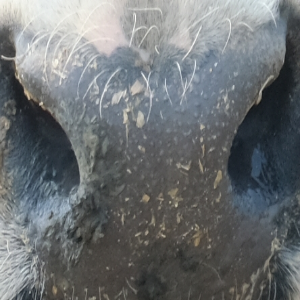

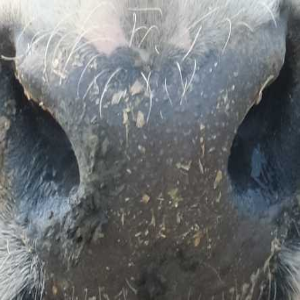

4.88 KB -> 0.89 KB



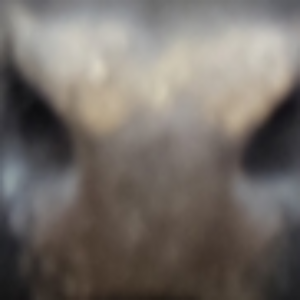

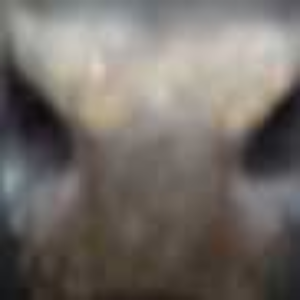

121.65 KB -> 17.81 KB



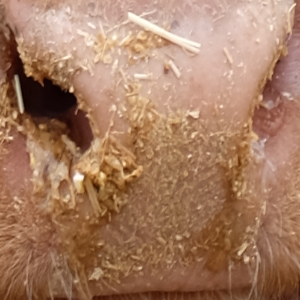

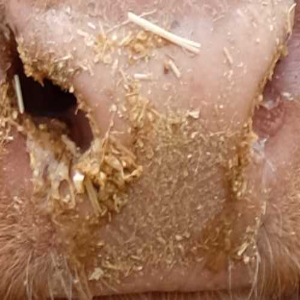

141.97 KB -> 16.67 KB



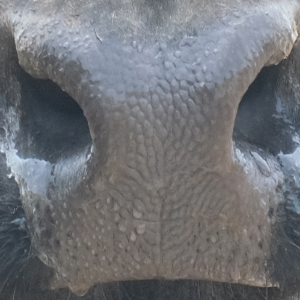

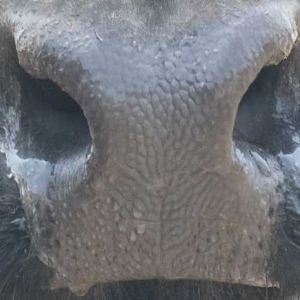

172.42 KB -> 21.93 KB



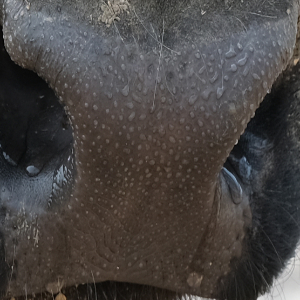

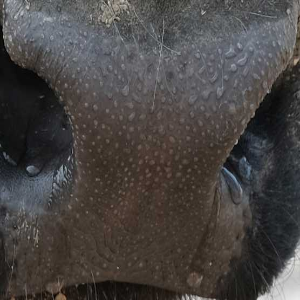

70.07 KB -> 7.86 KB



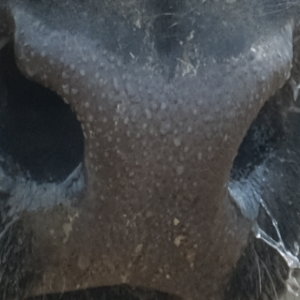

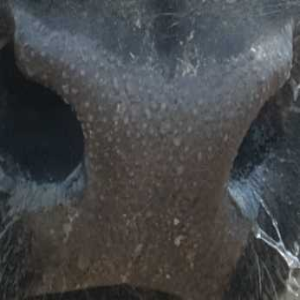

7.95 KB -> 1.13 KB



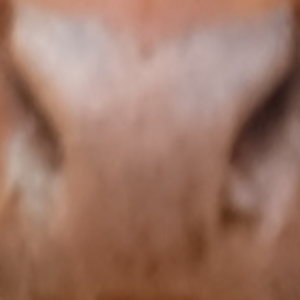

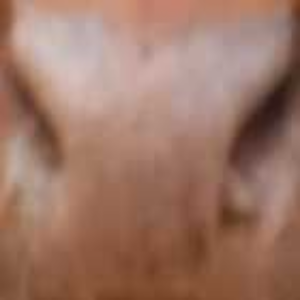

76.68 KB -> 10.10 KB



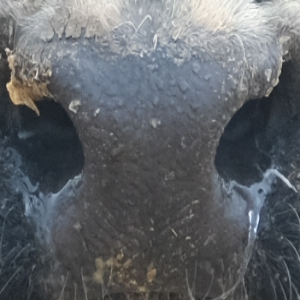

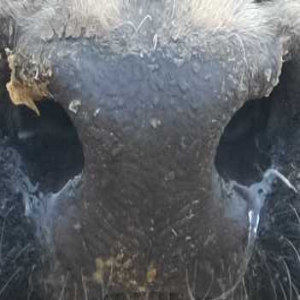

72.08 KB -> 10.14 KB



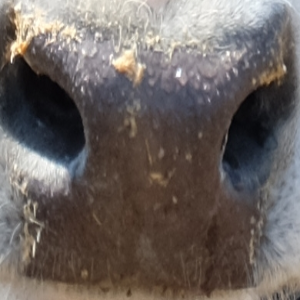

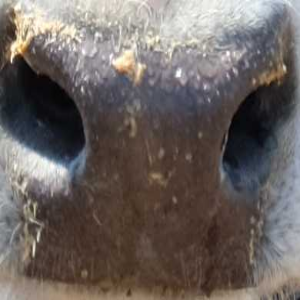

154.25 KB -> 16.53 KB



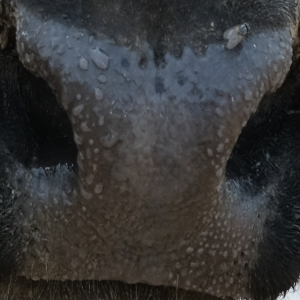

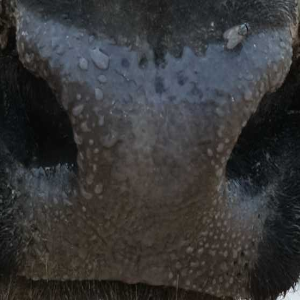

In [15]:
# sample image compression using default image format jpg
pill_compress(sample_src, sample_dest, "jpeg", 50, True)

### JPEG compression 50%

In [16]:
# run once

%%time
# Compress all images
pill_compress(src, dest, "jpeg", 50)

CPU times: user 1min 6s, sys: 2.15 s, total: 1min 9s
Wall time: 1min 8s


In [17]:
dest

'/content/AllDatasetCompressed/'

In [18]:
!ls $dest | wc -l

4923


### JPEG Compression 25%

In [19]:
# run once

%%time
# Compress all images
pill_compress(src, dest, "jpeg", 25)

CPU times: user 1min 3s, sys: 2.21 s, total: 1min 5s
Wall time: 1min 5s


### Confirm transfer

In [20]:
!ls /content/AllDataset2/ | wc -l

4923


In [21]:
!ls $dest | wc -l

4923


In [22]:

dest = "/content/AllDatasetCompressed/"

In [23]:
dest

'/content/AllDatasetCompressed/'

In [24]:
!ls $dest | wc -l

4923


In [25]:
!du -hs $dest

55M	/content/AllDatasetCompressed/


In [26]:
print(len(os.listdir(dest)))

4923


The train test split has been previously done, and extracted to a csv file. These csv files are read for both the train and test dataset. 

In [29]:
root_path = "/content/drive/MyDrive/datasplit_biometrics/"
train_csv = os.path.join(root_path, 'train_260_dataset.csv')
train_df = pd.read_csv(train_csv) 

train_df.head()

,image_id,label
0,cattle_5717_DSCF7510.jpg,5717
1,cattle_5360_DSCF0477.jpg,5360
2,cattle_6161_DSCF7349.jpg,6161
3,cattle_5774_DSCF6685.jpg,5774
4,cattle_5325_DSCF8207.jpg,5325


In [30]:
def correct_label(label):
  if len(str(label)) == 3:
    return "0" + str(label)
  else:
    return str(label)

In [31]:
train_df["label"] = train_df["label"].apply(correct_label)

In [ ]:
train_csv

'/content/drive/MyDrive/datasplit_biometrics/train_dataset.csv'

In [ ]:
#the train_df stores the filenames and their labels
train_df.image_id.iloc[0]

'cattle_5774_DSCF6685.jpg'

In [33]:
root_path = "/content/drive/MyDrive/datasplit_biometrics/"
test_csv = os.path.join(root_path, 'test_260_dataset.csv')
test_df = pd.read_csv(test_csv) 
test_df.head()

,image_id,label
0,cattle_5143_DSCF7971.jpg,5143
1,cattle_5083_DSCF9282.jpg,5083
2,cattle_5249_DSCF7379.jpg,5249
3,cattle_6287_DSCF7490.jpg,6287
4,cattle_4499_DSCF1223.jpg,4499


In [34]:
test_df["label"] = test_df["label"].apply(correct_label)

In [35]:
test_df

,image_id,label
0,cattle_5143_DSCF7971.jpg,5143
1,cattle_5083_DSCF9282.jpg,5083
2,cattle_5249_DSCF7379.jpg,5249
3,cattle_6287_DSCF7490.jpg,6287
4,cattle_4499_DSCF1223.jpg,4499
...,...,...
1325,cattle_5407_DSCF1037.jpg,5407
1326,cattle_6333_DSCF8761.jpg,6333
1327,cattle_6333_DSCF8782.jpg,6333
1328,cattle_3814_DSCF1557.jpg,3814


In [36]:
#We check if all labels are represented in the train data frist
train_unique_labels = train_df.label.unique()
len(train_unique_labels)  #This should return 261, which is the number of classes being considered

261

In [37]:
# concatenate the two dataframes vertically
df = pd.concat([train_df, test_df])

# print the resulting concatenated dataframe
df

,image_id,label
0,cattle_5717_DSCF7510.jpg,5717
1,cattle_5360_DSCF0477.jpg,5360
2,cattle_6161_DSCF7349.jpg,6161
3,cattle_5774_DSCF6685.jpg,5774
4,cattle_5325_DSCF8207.jpg,5325
...,...,...
1325,cattle_5407_DSCF1037.jpg,5407
1326,cattle_6333_DSCF8761.jpg,6333
1327,cattle_6333_DSCF8782.jpg,6333
1328,cattle_3814_DSCF1557.jpg,3814


In [38]:
#To perform a sort of encoding. Idx is from 1 to num_classes, class is as extracted from the dataset
idx_class_labels = {}
for ind, cattle in enumerate(df.label.unique()):
  # print(ind+1, ":", cattle)
  idx_class_labels[ind] = str(cattle)

class_idx_labels = {str(value): key for key, value in idx_class_labels.items()}

#Confirm that all labels present in all dataset is also present in train. Throws an error if this is not the case 
assert len(class_idx_labels) == len(train_unique_labels)

In [40]:
class_idx_labels;

In [42]:
#How the classes are extracted
each_file = "cattle_0200_DSCF3871.jpg"
each_file.split('_')[1]

'0200'

In [43]:
idx_class_labels

{0: '5717',
 1: '5360',
 2: '6161',
 3: '5774',
 4: '5325',
 5: '6294',
 6: '9736',
 7: '5083',
 8: '8094',
 9: '5097',
 10: '4456',
 11: '4947',
 12: '5373',
 13: '4649',
 14: '5208',
 15: '5215',
 16: '5171',
 17: '4614',
 18: '4716',
 19: '4921',
 20: '3400',
 21: '5781',
 22: '6184',
 23: '6210',
 24: '4339',
 25: '9773',
 26: '4537',
 27: '4840',
 28: '4385',
 29: '6333',
 30: '5408',
 31: '4748',
 32: '4895',
 33: '5283',
 34: '2300',
 35: '5670',
 36: '4680',
 37: '4985',
 38: '5605',
 39: '6277',
 40: '4678',
 41: '2220',
 42: '5410',
 43: '5971',
 44: '3200',
 45: '3802',
 46: '4499',
 47: '4820',
 48: '4686',
 49: '5090',
 50: '5537',
 51: '4613',
 52: '4770',
 53: '5077',
 54: '6276',
 55: '4986',
 56: '5658',
 57: '5403',
 58: '5314',
 59: '5273',
 60: '5620',
 61: '6278',
 62: '9635',
 63: '6022',
 64: '3832',
 65: '5407',
 66: '3844',
 67: '6038',
 68: '5235',
 69: '5836',
 70: '3812',
 71: '2930',
 72: '5359',
 73: '6458',
 74: '5953',
 75: '6283',
 76: '3300',
 77: '260

In [44]:
## Give idx of each class name
def encode_label(label):
    idx = class_idx_labels[str(label)] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return idx_class_labels[target]
    else:
        return target

## Show batches of images
def show_batch(dl):
    for images, labels in dl:
        # print(images)
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        # print(labels)
        break

In [45]:
print(encode_label("4679"))
print(decode_target(112))

114
6098


In [46]:
train_df = train_df.sample(frac = 1, random_state=48)
test_df = test_df.sample(frac = 1, random_state=48)

In [47]:
len(train_df)

3491

In [48]:
len(test_df)

1330

In [49]:
len(train_df) + len(test_df)

4821

In [50]:
train_df
train_df.reset_index(inplace = True) 
train_df.head()

,index,image_id,label
0,2711,cattle_4951_DSCF7411.jpg,4951
1,3413,cattle_6071_DSCF1095.jpg,6071
2,3298,cattle_5971_DSCF0353.jpg,5971
3,1654,cattle_9742_DSCF8521.jpg,9742
4,932,cattle_5143_DSCF7970.jpg,5143


In [51]:
train_df["label"].iloc[0]

'4951'

In [52]:
test_df.reset_index(inplace = True) 
test_df.head()

,index,image_id,label
0,1159,cattle_9634_DSCF8610.jpg,9634
1,116,cattle_4716_DSCF9197.jpg,4716
2,328,cattle_5654_DSCF9387.jpg,5654
3,354,cattle_4369_DSCF6755.jpg,4369
4,1281,cattle_4381_DSCF0112.jpg,4381


# Dataset and Dataloaders

In [53]:
class Biometrics(Dataset):
    def __init__(self, df, dirc, transform=None):
        self.train_dir = dirc
        self.train_df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['image_id'], row['label']
        img = Image.open(os.path.join(self.train_dir, img_id))
        # img = np.asarray(img)
        if self.transform:
            img = self.transform(img)

        #i.e when number is 3 digits, add 0 in front
        if len(str(label)) == 3:
          label = "0" + str(label)
        return img, encode_label(label)

Data augmentations

We explored horizontal flipping, brightness modification, randomized rotation, and blurring, which were explored in the original paper

In [54]:
# ## Dataset and transformations
train_data_transform = transforms.Compose([
                                transforms.Resize(size=(300, 300)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                                transforms.RandomRotation(20),
                                transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1, 2.0)),
                                transforms.ToTensor(),
                                ])

test_data_transform = transforms.Compose([
                                transforms.Resize(size=(300, 300)),
                                transforms.ToTensor(),
                                ])

In [55]:
train_ds = Biometrics(train_df, dest, train_data_transform)
test_ds = Biometrics(test_df, dest, test_data_transform)
print(len(train_ds), len(test_ds))

3491 1330


If the cell below runs, everything looks fine so far

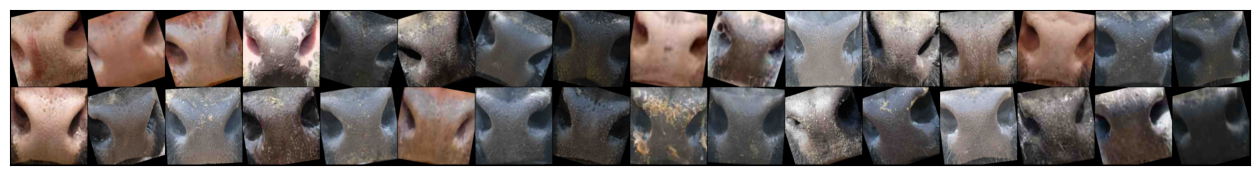

In [56]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
show_batch(train_dl)
#The images shown here are not preprocessed
#Images are black if normalized

In [57]:
#To get the number of classes
num_classes = len(class_idx_labels)

In [58]:
num_classes

261

# Model

In [59]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss

    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [60]:
num_classes

261

In [61]:
class AnimalBiometrics_Model(MulticlassClassifierBase):    
    def __init__(self):
            super().__init__()
            self.network = models.wide_resnet50_2(pretrained=True)
            n_inputs = self.network.fc.in_features
            self.network.fc = nn.Sequential(
                                  nn.Linear(n_inputs, 256),
                                  nn.ReLU(),
                                  nn.Dropout(0.5),
                                  nn.Linear(256, num_classes),
                                  nn.LogSoftmax(dim=1)
                                    )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [62]:
model = AnimalBiometrics_Model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:05<00:00, 27.2MB/s]


In [63]:
## Running through the data loader => Model => Output
def try_batch(dl):
    for images, labels in dl:
        # print(images[0])  
        print(images.shape)
        out = model(images)
        print(out.shape)
        print(out[0])
        print(labels)
        break
        
try_batch(train_dl)

torch.Size([32, 3, 300, 300])
torch.Size([32, 261])
tensor([-5.6591, -5.3795, -5.4403, -5.5316, -5.6255, -5.6315, -5.5851, -5.4601,
        -5.6076, -5.6586, -5.5152, -5.7849, -5.6117, -5.5503, -5.7117, -5.4595,
        -5.7928, -5.5666, -5.4792, -5.6637, -5.6394, -5.6227, -5.5691, -5.6888,
        -5.7432, -5.4253, -5.5518, -5.8090, -5.6648, -5.4078, -5.5745, -5.5487,
        -5.5765, -5.4618, -5.5246, -5.7477, -5.4268, -5.4814, -5.3100, -5.4159,
        -5.8248, -5.4071, -5.6456, -5.6262, -5.3477, -5.5240, -5.6779, -5.6969,
        -5.9087, -5.7531, -5.8945, -5.7392, -5.7654, -5.5160, -5.4275, -5.3998,
        -5.5750, -5.7522, -5.7568, -5.6351, -5.4450, -5.6124, -5.4435, -5.4029,
        -5.8647, -5.5922, -5.6019, -5.6621, -5.6310, -5.7405, -5.4426, -5.5978,
        -5.8075, -5.6166, -5.3501, -5.4835, -5.8807, -5.5840, -5.7408, -5.7286,
        -5.4405, -5.4399, -5.7403, -5.7031, -5.6787, -5.5523, -5.7037, -5.6324,
        -5.6937, -5.6545, -5.6753, -5.5262, -5.4472, -5.7036, -5.433

The current challenge is that the out is very off with negative values

Training and Evaluation

In [64]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):
  
    history = []
    valid_loss_min = np.Inf
    valid_acc_max = 0
    model_file_name = 'abc.pth'
    model_file_name2 = 'abc_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
                         
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):
            
            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
            
            
        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############                                         
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history                                
                                                 
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

Initializing Device also Loading Data and Model to device

In [65]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
        
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [66]:
device = get_device()
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
## Loading model to device
model = to_device(AnimalBiometrics_Model(), device)
## lets try passing a batch to model again
try_batch(train_dl)

True
torch.Size([32, 3, 300, 300])
torch.Size([32, 261])
tensor([-5.3546, -5.8150, -5.7299, -5.4726, -5.6548, -5.7100, -5.3494, -5.5793,
        -5.4986, -5.4181, -5.6757, -5.5675, -5.4014, -5.6468, -5.7751, -5.5211,
        -5.4997, -5.4896, -5.5064, -5.6269, -5.6497, -5.3645, -5.6400, -5.7353,
        -5.8163, -5.3590, -5.5810, -5.5975, -5.5756, -5.6944, -5.3921, -5.4324,
        -5.6434, -5.4234, -5.6387, -5.5324, -5.3793, -5.7427, -5.4238, -5.4572,
        -5.4518, -5.5798, -5.4750, -5.4283, -5.4197, -5.4026, -5.7626, -5.6298,
        -5.5566, -5.4935, -5.5734, -5.7746, -5.5939, -5.5173, -5.6585, -5.5999,
        -5.4600, -5.5785, -5.6364, -5.5460, -5.5119, -5.5493, -5.6785, -5.8554,
        -5.6499, -5.4197, -5.5930, -5.5097, -5.6879, -5.6366, -5.4346, -5.7955,
        -5.5616, -5.4626, -5.5438, -5.6297, -5.4159, -5.6759, -5.4377, -5.7030,
        -5.5293, -5.4708, -5.6433, -5.7998, -5.7247, -5.6547, -5.6144, -5.7034,
        -5.5606, -5.3816, -5.4829, -5.7215, -5.4996, -5.6557, -

In [67]:
torch.cuda.empty_cache()

In [68]:
# Hyper Parameters
max_epochs_stop = 5
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 0
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 50
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model, test_dl)

{'val_loss': 5.575829982757568, 'val_acc': 0.0007440476329065859}

In [69]:
torch.cuda.empty_cache()

In [70]:
%%time

## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, test_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

100%|██████████| 110/110 [00:25<00:00,  4.27it/s]


Epoch [0],train_accu: 0.0741, learning_rate: 0.0001, train_loss: 5.1602, val_loss: 4.1152, val_acc: 0.2779


100%|██████████| 110/110 [00:25<00:00,  4.25it/s]


Epoch [1],train_accu: 0.3000, learning_rate: 0.0001, train_loss: 3.7692, val_loss: 2.4347, val_acc: 0.5725


100%|██████████| 110/110 [00:24<00:00,  4.40it/s]


Epoch [2],train_accu: 0.5336, learning_rate: 0.0001, train_loss: 2.5309, val_loss: 1.4013, val_acc: 0.7197


100%|██████████| 110/110 [00:24<00:00,  4.45it/s]


Epoch [3],train_accu: 0.6929, learning_rate: 0.0001, train_loss: 1.7127, val_loss: 0.8129, val_acc: 0.8204


100%|██████████| 110/110 [00:24<00:00,  4.49it/s]


Epoch [4],train_accu: 0.7818, learning_rate: 0.0001, train_loss: 1.1847, val_loss: 0.4719, val_acc: 0.8991


100%|██████████| 110/110 [00:24<00:00,  4.42it/s]


Epoch [5],train_accu: 0.8514, learning_rate: 0.0001, train_loss: 0.8024, val_loss: 0.2658, val_acc: 0.9402


100%|██████████| 110/110 [00:25<00:00,  4.38it/s]


Epoch [6],train_accu: 0.9006, learning_rate: 0.0001, train_loss: 0.5443, val_loss: 0.1422, val_acc: 0.9668


100%|██████████| 110/110 [00:24<00:00,  4.42it/s]


Epoch [7],train_accu: 0.9346, learning_rate: 0.0001, train_loss: 0.4127, val_loss: 0.0990, val_acc: 0.9728


100%|██████████| 110/110 [00:25<00:00,  4.39it/s]


Epoch [8],train_accu: 0.9537, learning_rate: 0.0001, train_loss: 0.2886, val_loss: 0.0664, val_acc: 0.9801


100%|██████████| 110/110 [00:24<00:00,  4.43it/s]


Epoch [9],train_accu: 0.9545, learning_rate: 0.0001, train_loss: 0.2609, val_loss: 0.0576, val_acc: 0.9853


100%|██████████| 110/110 [00:25<00:00,  4.37it/s]


Epoch [10],train_accu: 0.9639, learning_rate: 0.0001, train_loss: 0.2100, val_loss: 0.0511, val_acc: 0.9823


100%|██████████| 110/110 [00:25<00:00,  4.40it/s]


Epoch [11],train_accu: 0.9710, learning_rate: 0.0001, train_loss: 0.1665, val_loss: 0.0591, val_acc: 0.9786


100%|██████████| 110/110 [00:25<00:00,  4.36it/s]


Epoch [12],train_accu: 0.9760, learning_rate: 0.0001, train_loss: 0.1590, val_loss: 0.0325, val_acc: 0.9890


100%|██████████| 110/110 [00:25<00:00,  4.27it/s]


Epoch [13],train_accu: 0.9713, learning_rate: 0.0001, train_loss: 0.1657, val_loss: 0.0472, val_acc: 0.9860


100%|██████████| 110/110 [00:25<00:00,  4.26it/s]


Epoch [14],train_accu: 0.9712, learning_rate: 0.0001, train_loss: 0.1607, val_loss: 0.1446, val_acc: 0.9786


100%|██████████| 110/110 [00:25<00:00,  4.31it/s]


Epoch [15],train_accu: 0.9741, learning_rate: 0.0001, train_loss: 0.1394, val_loss: 0.0605, val_acc: 0.9866


100%|██████████| 110/110 [00:25<00:00,  4.31it/s]


Epoch [16],train_accu: 0.9876, learning_rate: 0.0000, train_loss: 0.0715, val_loss: 0.0311, val_acc: 0.9911


100%|██████████| 110/110 [00:25<00:00,  4.37it/s]


Epoch [17],train_accu: 0.9910, learning_rate: 0.0000, train_loss: 0.0632, val_loss: 0.0288, val_acc: 0.9905


100%|██████████| 110/110 [00:25<00:00,  4.32it/s]


Epoch [18],train_accu: 0.9832, learning_rate: 0.0000, train_loss: 0.0760, val_loss: 0.0263, val_acc: 0.9920


100%|██████████| 110/110 [00:25<00:00,  4.32it/s]


Epoch [19],train_accu: 0.9891, learning_rate: 0.0000, train_loss: 0.0561, val_loss: 0.0281, val_acc: 0.9890


100%|██████████| 110/110 [00:25<00:00,  4.32it/s]


Epoch [20],train_accu: 0.9943, learning_rate: 0.0000, train_loss: 0.0497, val_loss: 0.0275, val_acc: 0.9905


100%|██████████| 110/110 [00:25<00:00,  4.35it/s]


Epoch [21],train_accu: 0.9930, learning_rate: 0.0000, train_loss: 0.0575, val_loss: 0.0288, val_acc: 0.9905


100%|██████████| 110/110 [00:25<00:00,  4.32it/s]


Epoch [22],train_accu: 0.9866, learning_rate: 0.0000, train_loss: 0.0806, val_loss: 0.0278, val_acc: 0.9897


100%|██████████| 110/110 [00:25<00:00,  4.33it/s]


Epoch [23],train_accu: 0.9908, learning_rate: 0.0000, train_loss: 0.0521, val_loss: 0.0285, val_acc: 0.9905


100%|██████████| 110/110 [00:25<00:00,  4.36it/s]


Epoch [24],train_accu: 0.9924, learning_rate: 0.0000, train_loss: 0.0512, val_loss: 0.0259, val_acc: 0.9905


100%|██████████| 110/110 [00:25<00:00,  4.34it/s]


Epoch [25],train_accu: 0.9908, learning_rate: 0.0000, train_loss: 0.0612, val_loss: 0.0270, val_acc: 0.9905


100%|██████████| 110/110 [00:25<00:00,  4.39it/s]


Epoch [26],train_accu: 0.9897, learning_rate: 0.0000, train_loss: 0.0487, val_loss: 0.0269, val_acc: 0.9905


100%|██████████| 110/110 [00:25<00:00,  4.34it/s]


Epoch [27],train_accu: 0.9916, learning_rate: 0.0000, train_loss: 0.0584, val_loss: 0.0280, val_acc: 0.9905


100%|██████████| 110/110 [00:25<00:00,  4.33it/s]


Epoch [28],train_accu: 0.9888, learning_rate: 0.0000, train_loss: 0.0623, val_loss: 0.0283, val_acc: 0.9897


100%|██████████| 110/110 [00:25<00:00,  4.27it/s]


Epoch [29],train_accu: 0.9866, learning_rate: 0.0000, train_loss: 0.0667, val_loss: 0.0268, val_acc: 0.9912


100%|██████████| 110/110 [00:25<00:00,  4.33it/s]


Epoch [30],train_accu: 0.9927, learning_rate: 0.0000, train_loss: 0.0496, val_loss: 0.0282, val_acc: 0.9912
Early Stopping............................
CPU times: user 6min 5s, sys: 53.9 s, total: 6min 59s
Wall time: 15min 39s


In [71]:
#Save model
torch.save(model.state_dict(),"/content/wideresnet_model_with261classes.pt")

In [72]:
try_batch(train_dl)

torch.Size([32, 3, 300, 300])
torch.Size([32, 261])
tensor([-1.1585e+01, -1.7474e+01, -1.4753e+01, -1.7257e+01, -1.9372e+01,
        -1.5831e+01, -1.4635e+01, -1.4502e+01, -1.6714e+01, -1.8837e+01,
        -1.7790e+01, -1.6058e+01, -1.6764e+01, -1.4988e+01, -1.6321e+01,
        -1.4956e+01, -1.8050e+01, -1.7071e+01, -1.4609e+01, -1.6643e+01,
        -2.1118e+01, -1.6292e+01, -1.8950e+01, -1.4926e+01, -1.3963e+01,
        -1.5426e+01, -1.8898e+01, -1.5647e+01, -2.0100e+01, -2.1002e+01,
        -2.0078e+01, -1.6825e+01, -1.5750e+01, -1.7489e+01, -1.9221e+01,
        -1.4438e+01, -1.7417e+01, -1.7623e+01, -1.5836e+01, -1.5836e+01,
        -1.6721e+01, -1.7833e+01, -2.1113e+01, -1.6331e+01, -1.6487e+01,
        -1.7663e+01, -2.0073e+01, -1.4839e+01, -1.7882e+01, -1.1483e+01,
        -1.5853e+01, -1.5986e+01, -1.6372e+01, -1.8162e+01, -1.6243e+01,
        -1.6532e+01, -1.6682e+01, -1.4727e+01, -1.6646e+01, -1.9562e+01,
        -1.9194e+01, -1.8244e+01, -1.2587e+01, -1.9124e+01, -1.8982e+01,

In [73]:
%%time
evaluate(model, test_dl)

CPU times: user 1.87 s, sys: 405 ms, total: 2.27 s
Wall time: 4.18 s


{'val_loss': 0.028226716443896294, 'val_acc': 0.9912367463111877}

In [74]:
len(test_dl)

42

In [75]:
model.eval()
batch_bar = tqdm(total=len(test_dl), dynamic_ncols=True, position=0, leave=False, desc='Test')

res = []
actual = []
img = []
for i, (x, label) in enumerate(test_dl):
    actual.extend(label)

    # Finish predicting on the test set.
    x = x.cuda()
    with torch.no_grad():
        outputs = model(x)

        pred_y = torch.argmax(outputs, axis=1)
        res.extend(pred_y.tolist())
        img.extend(x)
    
    batch_bar.update()
    
batch_bar.close()

In [76]:
res[:10]

[121, 18, 146, 86, 241, 191, 243, 130, 111, 9]

In [77]:
actual[:10]

[tensor(121, device='cuda:0'),
 tensor(18, device='cuda:0'),
 tensor(146, device='cuda:0'),
 tensor(86, device='cuda:0'),
 tensor(241, device='cuda:0'),
 tensor(191, device='cuda:0'),
 tensor(243, device='cuda:0'),
 tensor(130, device='cuda:0'),
 tensor(111, device='cuda:0'),
 tensor(9, device='cuda:0')]

In [78]:
3/train_df.shape[0]

0.0008593526210254941

In [79]:
# Check if CUDA is available
if torch.cuda.is_available():

    # Get the name of the GPU
    gpu_name = torch.cuda.get_device_name(0)
    print("GPU: ", gpu_name)

else:
    print("No GPU available.")


GPU:  NVIDIA A100-SXM4-40GB


In [80]:
import torch

print(torch.__version__)


2.0.0+cu118
